In [40]:
#Import statements
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import community
from collections import Counter
from networkx.readwrite import json_graph
from datetime import datetime
import requests
import requests_cache
import certifi
import re
import json
import sys
import pickle
from wordcloud import WordCloud
#Load the pickled data
with open('mails.pickle', 'rb') as handle:
    data = pickle.load(handle)

print("Loaded ",len(data), " Emails from Pickle")

Loaded  33627  Emails from Pickle


# Part 1: Project Synopsis

This notebooks is a technical insight into how the analysis and extraction of over 30.000 of Hillary Clintons leaked emails has come about. The notebook is in three parts.

* Data extraction and statistics
* Network analysis
* Natural Language Processing and Topic Extraction

In this project we will examine Hillary Clintons leaked emails. We will extract and clean over 30.000 emails and create a network and corresponding email corpus. The idea is to explore the large quantities of data using simple statistics and analysis learned throughout the course. 

For the network we will look at the degree distribution and centrality measures to find the most central persons in the email data. Then we will use the Python-louvain algorithm to find some communities in the network. Does the semantics of these communities correspond with what we would expect in the real world, and does the partitioning make sense? 

In the Text analysis section we will be looking at the extracted text from the emails to figure out topics. We will be looking at the topic extraction of the entire corpus, for the most central persons, for the communities and finally for significant dates with a lot of emails. Does these topics represent the collections of emails correctly, and is it what we expected? The Data is relatively new, released in March of 2017 by the FOIA https://foia.state.gov/. I heard alot about the Hillary Clinton mails from the media, and wanted to explore them for my self. 

Make sure to check out the website which the data and insights produced here has been used for. The initial idea was to do both Sentiment analysis and Topic extraction for the text of the emails. I found that the sentiment profiles were not very good, and provided little to no information about the subjectivity or volatility of the emails. Instead i have chosen to focus on the Topic Extraction part of the NLP section as it proved to be more sucessful. 

# Part 2: Data extraction and basic statistics

This part is not the most exciting but it's the one that took me the most time to get right. Finding a PDF extracter that did not have a bunch of small issues where almost impossible. One extractor "slate" could not convert newlines to whitespace on the next line, and grouped way too many words. Another kept all the formatting, but the OCR was bad, capital I would turn to lowercase l and so on. Finally i found a PDF parser that worked a little bit better, although some of the OCR is not perfect. I use the Python 3 package ( Yes i had to change from Python 2.7 to Python 3 just to use this one package ) "import pdftotext"

To get the emails i Query "https://foia.state.gov/searchapp/Search/SubmitSimpleQuery" using the code below. The code is inspired by the Github project https://github.com/benhamner/hillary-clinton-emails/tree/master/scripts which reads the data into an SQLlite database. I did not want to do this, so i just borrowed the script used to query the FOIA, as i could not find any documentation elsewhere on how to do this. And i did not want to just download the Data from Kaggle as i wanted to preprocess the text myself. 

I print some of the parsing errors to get an idea of how severe it is, with these packages it only finds a few errors in some of the files. If we get a parsing error, we just set the email to being empty, so it wont contribute to the analysis.

In [2]:
#!/usr/bin/env python
# encoding: utf-8

requests_cache.install_cache("metadata_cache",expire_after=300)

query = "https://foia.state.gov/searchapp/Search/SubmitSimpleQuery"

def getEmail(start=0,limit=1000,page=1):
    params = {"searchText": "*",
    "beginDate": "false",
    "endDate": "false",
    "collectionMatch": "Clinton_Email",
    "postedBeginDate": "false",
    "postedEndDate": "false",
    "caseNumber": "false",
    "page":page,
    "start": start,
    "limit": limit}
    
    request = requests.get(query,params=params)
    return_json = request.text
    

    return_json = re.sub(r'new Date\(([0-9]{1,})\)',r'\1',return_json)
    return_json = re.sub(r'new ?Date\((-[0-9]{1,})\)',r'null',return_json)
    return json.loads(return_json)

def compileResultsList(results=[],start=0, limit=1000):
    response = getEmail(start=start,limit=limit)
    results.extend(response["Results"])
    if len(results) < response["totalHits"]:
        start += limit
        compileResultsList(results=results,start=start,limit=limit)
        
    return results
    
def formatTimestamp(timestamp):
    try:
        return datetime.fromtimestamp(timestamp/1000).strftime("%Y-%m-%d")
    except TypeError:
        return None

results_list = compileResultsList()
print("got",len(results_list),"total document/emails")

got 33627 total document/emails


In [3]:
import pdftotext

for idx in range(len(results_list)):
    if(idx%1000 == 0):
        print("Converted", idx," out of ",len(results_list))
    file = "data/"+results_list[idx]["pdfLink"].split("/")[-1]
    # Load your PDF
    try:
        with open(file, "rb") as f:
            pdf = pdftotext.PDF(f)
            text = ""
            for page in pdf:
                text = text + " " + page
            text = ' '.join(text.split())
            results_list[idx]["content"] = text
    except:
        print("File not found: ",file)

Converted 0  out of  33627
File not found:  data/C06187565.pdf
File not found:  data/C06174309.pdf
File not found:  data/C06174276.pdf
File not found:  data/C06174275.pdf
File not found:  data/C06181680.pdf
File not found:  data/C06179975.pdf
File not found:  data/C06179974.pdf
File not found:  data/C06179832.pdf
File not found:  data/C06179808.pdf
File not found:  data/C06179780.pdf
File not found:  data/C06179775.pdf
File not found:  data/C06171895.pdf
File not found:  data/C06171884.pdf
File not found:  data/C06171883.pdf
File not found:  data/C06171881.pdf
File not found:  data/C06171875.pdf
File not found:  data/C06171871.pdf
File not found:  data/C06171847.pdf
File not found:  data/C06171801.pdf
File not found:  data/C06171791.pdf
File not found:  data/C06171788.pdf
File not found:  data/C06171786.pdf
File not found:  data/C06171689.pdf
Converted 1000  out of  33627
Converted 2000  out of  33627
Converted 3000  out of  33627
Converted 4000  out of  33627
Converted 5000  out of  3

In this cell i had to manually check for certain keywords to aggregate the various email aliases. An example is that Hillary Clinton can be Hillary Clinton, Clinton Hillary her email, "Secretary" or even just "H". This goes for all of the alises. I decided to clean the top 10 most popular aliases, also because i could search for their names online. For the rest, the aliases are as is. 

In [4]:
count = 0
data = results_list
# Clean senders aliases, as they have all kinds of different naming conventions
# This approach is quite bad, but there is no way to know what aliases go together
for idx in range(len(data)):
    count+=1
    try:
        if(data[idx]["to"] == "H"):
            data[idx]["to"] = "Hillary Clinton"

        if(data[idx]["from"] == "H"):
            data[idx]["from"] = "Hillary Clinton"
        if("hillary" in str.lower(data[idx]["to"]) or "clinton" in str.lower(data[idx]["to"]) or "secretary" in str.lower(data[idx]["to"])):
            data[idx]["to"] = "Hillary Clinton"
        if("hillary" in str.lower(data[idx]["from"])):
            data[idx]["from"] = "Hillary Clinton"
        if("abedin" in str.lower(data[idx]["to"])):
            data[idx]["to"] = "Huma Abedin"
        if("abedin" in str.lower(data[idx]["from"])):
            data[idx]["from"] = "Huma Abedin"
        #Cheryl Mills
        if("mills" in str.lower(data[idx]["to"])):
            data[idx]["to"] = "Cheryl Mills"
        if("mills" in str.lower(data[idx]["from"])):
            data[idx]["from"] = "Cheryl Mills"
        #Sulivan
        if("sullivan" in str.lower(data[idx]["to"])):
            data[idx]["to"] = "Jacob Sullivan"
        if("sullivan" in str.lower(data[idx]["from"])):
            data[idx]["from"] = "Jacob Sullivan"
        if("jiloty" in str.lower(data[idx]["to"])):
            data[idx]["to"] = "Lauren Jiloty"
        if("jiloty" in str.lower(data[idx]["from"])):
            data[idx]["from"] = "Lauren Jiloty"
        if("hanley" in str.lower(data[idx]["to"])):
            data[idx]["to"] = "Monica Hanley"
        if("hanley" in str.lower(data[idx]["from"])):
            data[idx]["from"] = "Monica Hanley"
        
    except:
        continue
print(count)

33627


Now with the raw text extracted using the PDF parser, it's time to extract the actual message of the email. To get an idea of how difficult this actuall was and how much time i spent on getting it just right i have included an image of one of the 30000 PDFs

<img src="PDF.PNG" alt="title" >

The PDF parser will parse everything, from the header, to the original message. Everything. The correct parsed string in this situation is "See note below". This is because the Metadata only fits on the top message of the PDF. If we are lucky, there will be other PDF documents with the original message, but we can't be sure. Parsing the mail string down is kind of impossible, because the "From" and "Sent" might contain aliases we have not seen before.

Lets see what the script has actually parsed.

In [61]:
print(data[0]["pdfLink"].split("/")[-1])
for mail in data:
    if(mail["pdfLink"].split("/")[-1] == "C05739591.pdf"):
        print("Text: ", mail["extractedContent"])
        print("From: ",mail["from"])
        print("To: ", mail["to"])

C06187565.pdf
Text:  See note below
From:  Huma Abedin
To:  Hillary Clinton


And i'm quite happy with the result. The parser is doing what it should. The code with all the regular expressions and statements are below.

There are 4 cases of Emails of decreasing priority. FOIA gives us the subject line. The first regular expression parses everything after the subject until "Original Message" or "From". If this doesnt match anything, we try again but we take everything after the subject, if this again does not work, we don't care about the subject, and match from "To" to Original Message or "from". If this doesnt work, we just match everything from "To". The last clause is the worst case to match, as it has the highest chance or taking too much. 

Next the text is filtered for words like "CLASSIFIED" and words that appear in the headers. After everything is done, the text should be completely cleaned, although there are some corner cases which are not handled. The extracting and parsing took maybe 50% of the time for the entire project to get it exactly right, and it is still not perfect. 

In [5]:
def extract_body(raw_text,subject):
    #subject = re.sub('[^a-zA-Z\s]+', '', subject)
    subject = re.sub('\.','\.',subject)
    m = re.search(r"(?:"+subject+")(.*?)(Original Message|From:)", raw_text, flags=re.DOTALL|re.IGNORECASE)
    if m:
        #print("First line")
        return filter_body(m.groups()[0])
    m = re.search(r"(?:"+subject+")(.*)", raw_text, flags=re.DOTALL|re.IGNORECASE)
    if m:
        #print("Second Line")
        #print(m.groups())
        return filter_body(m.groups()[0])
    m = re.search(r"\nTo:.*?\n(.*?)(Original Message|From:)", raw_text, flags=re.DOTALL|re.IGNORECASE)
    if m:
        #print("Third Line")
        return filter_body(m.groups()[0])
    m = re.search(r"\nTo:.*?\n(.+)", raw_text, flags=re.DOTALL|re.IGNORECASE)
    if m:
        #print("Fourth Line")
        return filter_body(m.groups()[0])
    #print("Nothing")
    return ""

def filter_body(text):
    patterns = [r"\x0c",
                r"UNCLASSIFIED.*",
                r"CONFIDENTIAL.*",
                r"Classified by.*",
                r"Attachments:.*"]
    for repeat in range(3):
        for pattern in patterns:
            #print(text)
            text = re.sub(pattern, "", text)
    return text.strip()


for email in data:
    try:
        email["extractedContent"] = extract_body(email["content"],email["subject"])
    except Exception as e:
        #If the extracted content has like a parsing error, it needs to be empty.
        email["extractedContent"] = " "
        print(e)
        


'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
'content'
multiple repeat at position 53
expected string or bytes-like object
unbalanced parenthesis at position 56
unbalanced parenthesis at position 109
unbalanced parenthesis at position 109
nothing to repeat at position 3
bad character range S-C at position 36
nothing to repeat at position 3
multiple repeat at position 30
missing ), unterminated subpattern at position 0
expected string or bytes-like object
expected string or bytes-like object
expected string or bytes-like object
expected string or bytes-like object
nothing to repeat at position 3
nothing to repeat at position 3
unbalanced parenthesis at position 5
unterminated character set at position 3
bad character range H-G at position 84
multiple repeat at position 7
multiple repeat at position 7
multiple repea

In [6]:
#Save the extracted and cleaned data into Pickle
for mail in data:
    for key,value in mail.items():
        if(value == None):
            value = " "
            
with open('mails.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Part3: Network analysis

We will in this notebook consider two different models for the network. In the first section we will model the network as a Multi Directed Graph, where each node is a person, and each edge is a mail with a direction "From" to "To" in the email. This means that there are a lot of edges, as two persons can have a lot of mails between them. This creates a quite messy network, and the centrality measures then becomes a measure of mail-throughput and not so much how central or connected each node is.

In the second model we simplify the network. Each node is still a person, but there is now only one weighted edge between two persons if they had a correspondance. The weight is described by the number of mails between the two persons. This makes it possible to get centrality measures that can actually describe connectedness and centrality, as a nodes degree is now a measure of how many different persons this person is connected to. 

We first consider the Multi Directed Graph

## Create the network as a Multi Directed Graph

Creating the network as a Multi Directed Graph is really simple because of the way the data has been extracted. For each mail we just add an edge from "From" to "To" and that will automatically create all the correct edge links with directions and all the nodes. Note that the number of edges is the total number of email in the dataset.

In [7]:
#Load the data
with open('mails.pickle', 'rb') as handle:
    data = pickle.load(handle)

print("Loaded: ", len(data)," rows!")

G = nx.MultiDiGraph()
for mail in data:
    if(mail["from"] == None or mail["to"] == None):
        continue
    G.add_edge(str.lower(mail["from"]),str.lower(mail["to"]))

print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of Edges: {}".format(G.number_of_edges()))

33627
Number of nodes: 952
Number of Edges: 33626


Then we calculate the In degree and out Degree to plot the degree distribution, and find the persons with the most mails going in and the persons with the most mails going out.

In [8]:
degrees_in = {}
degrees_out = {}

for person in G.nodes():
    #This ensures that badly formatted nodes does not get counted
    if(person == "H" or person == ""):
        continue
        
    count = 0
    #In degree is edge[1]
    for linkto in [edge[1] for edge in G.edges()]:
        if person == linkto:
            count += 1
    degrees_in[person] = count
    
    count = 0
    #Out degree is edge[0]
    for linkfrom in [edge[0] for edge in G.edges()]:
        if person == linkfrom:
            count += 1
    degrees_out[person] = count

Now we create a simple plot as we have done in previous exercises, to plot the degree distribution. As this network is highly skewed the degree distribution will have a lot of nodes with low degree, and few nodes with a high degree.


Max_out 9547
Max_in 22016


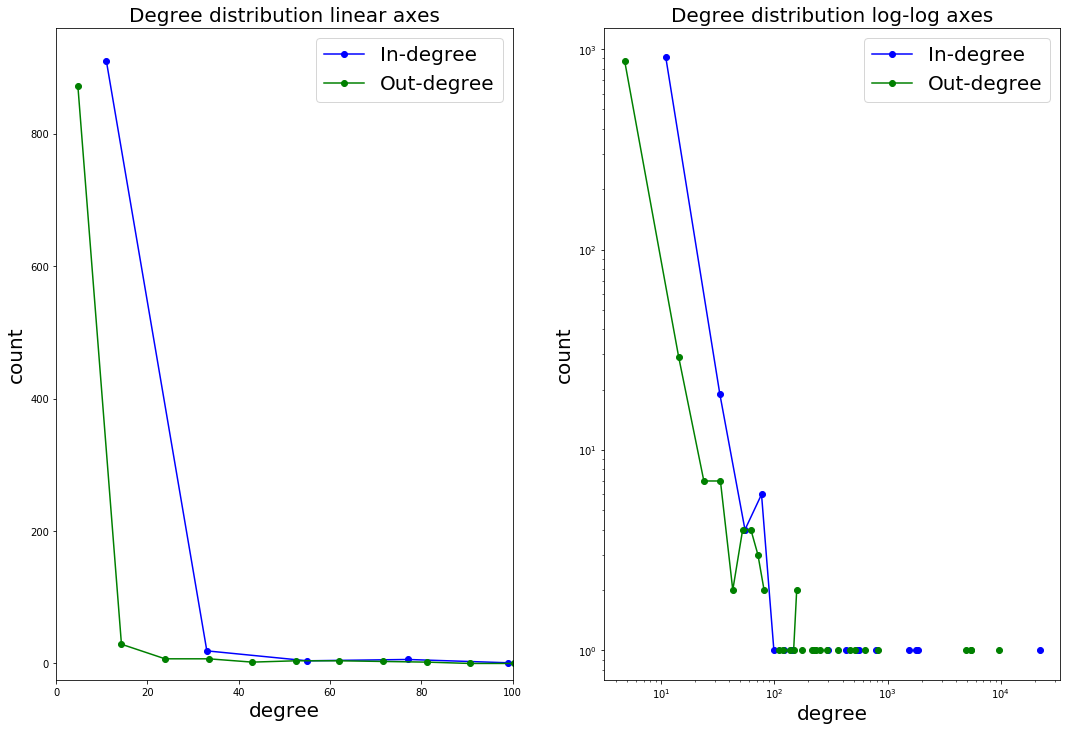

In [9]:
# Find min and max values for ingoing and outgoing degrees
min_deg_in = min(degrees_in.values())
max_deg_in = max(degrees_in.values())
min_deg_out = min(degrees_out.values())
max_deg_out = max(degrees_out.values())

print("Max out degree",max_deg_out)
print("Max in degree",max_deg_in)
# Bin the degree distributions
numBims = 1000
bins_in = np.histogram(list(degrees_in.values()), bins=numBims)
bins_out = np.histogram(list(degrees_out.values()), bins=numBims)

# Find the centers for each bin
bin_centers_in = []
bin_centers_out = []
for i in range(len(bins_in[1])-1):
    center = (bins_in[1][i]+bins_in[1][i+1])/2
    bin_centers_in.append(center)
for i in range(len(bins_out[1])-1):
    center = (bins_out[1][i]+bins_out[1][i+1])/2
    bin_centers_out.append(center)
    
# Plot degree distributions with linear axis and log axis
plt.figure(figsize=(18, 12))

plt.subplot(121)
line1,=plt.plot(bin_centers_in, bins_in[0], 'bo-', label='In-degree')
line2,=plt.plot(bin_centers_out, bins_out[0], 'go-', label='Out-degree')
plt.axis([0, 100, -25, max(max(bins_in[0]),max(bins_out[0]))+50])
plt.xlabel('degree',fontsize=20)
plt.ylabel('count',fontsize=20)
plt.title('Degree distribution linear axes',fontsize=20)
plt.legend(handles=[line1,line2],fontsize=20)

plt.subplot(122)
line3,=plt.loglog(bin_centers_in, bins_in[0], 'bo-', label='In-degree')
line4,=plt.loglog(bin_centers_out, bins_out[0], 'go-', label='Out-degree')
plt.xlabel('degree',fontsize=20)
plt.ylabel('count',fontsize=20)
plt.title('Degree distribution log-log axes',fontsize=20)
plt.legend(handles=[line3,line4],fontsize=20)

plt.savefig('deg_dist.png')
plt.show()


# Most popular people in the network.

Based on this graph and degree distribution we can figure out who are the persons who are most active behind the computer. These are the persons in Hillary Clintons mail chain that has received or sent most emails. Note we don't distinguish if the mails all go to the same person, only how many there are.     

In [10]:
popular_in = {}
popular_out = {}

print("Most popular people, by in degree (Received Mails)")
for person in sorted(degrees_in.items(), key=lambda x:x[1],reverse=True)[0:10]:
    popular_in[person[0]] = {
        "corpus": "",
    }
    print(person)
    
print("\nMost popular people, by out degree (Sent Mails)")
for person in sorted(degrees_out.items(), key=lambda x:x[1],reverse=True)[0:10]:
    popular_out[person[0]] = {
        "corpus": "",
    }
    print(person)

Most popular people, by in degree (Received Mails)
('hillary clinton', 22016)
('huma abedin', 1852)
('jacob sullivan', 1766)
('cheryl mills', 1523)
('lauren jiloty', 789)
('russorv@state.gov', 558)
('monica hanley', 532)
('valmorolj@state.gov', 419)
('oscar flores', 290)
('sbwhoeop', 145)

Most popular people, by out degree (Sent Mails)
('hillary clinton', 9547)
('huma abedin', 5466)
('cheryl mills', 5414)
('jacob sullivan', 4926)
('lauren jiloty', 830)
('monica hanley', 630)
('sbwhoeop', 518)
('valmoro, lona j', 463)
('slaughter, anne-marie', 363)
('coleman, claire l', 292)


To no surprise Hillary Clinton has received 21615 mails and sent 9533 and she is the most active user (This is a dump of her personal mails so it is no surprise). This does not sum to the total amount of mails, which suggests that there are some mistakes in the data. This could be some aliases that has not been cleaned properly, or some emails that is between persons other than Hillary, where Hillary is CC. 


Next we use the spring layout algorithm from NetworkX to plot the network. And as we will see the network is really messy. One observation is that there are alot of components that have only received a single link. These are emails that has been sent to Hillary Clinton, but which have never been replied to. These make up the majority of nodes in the network. 

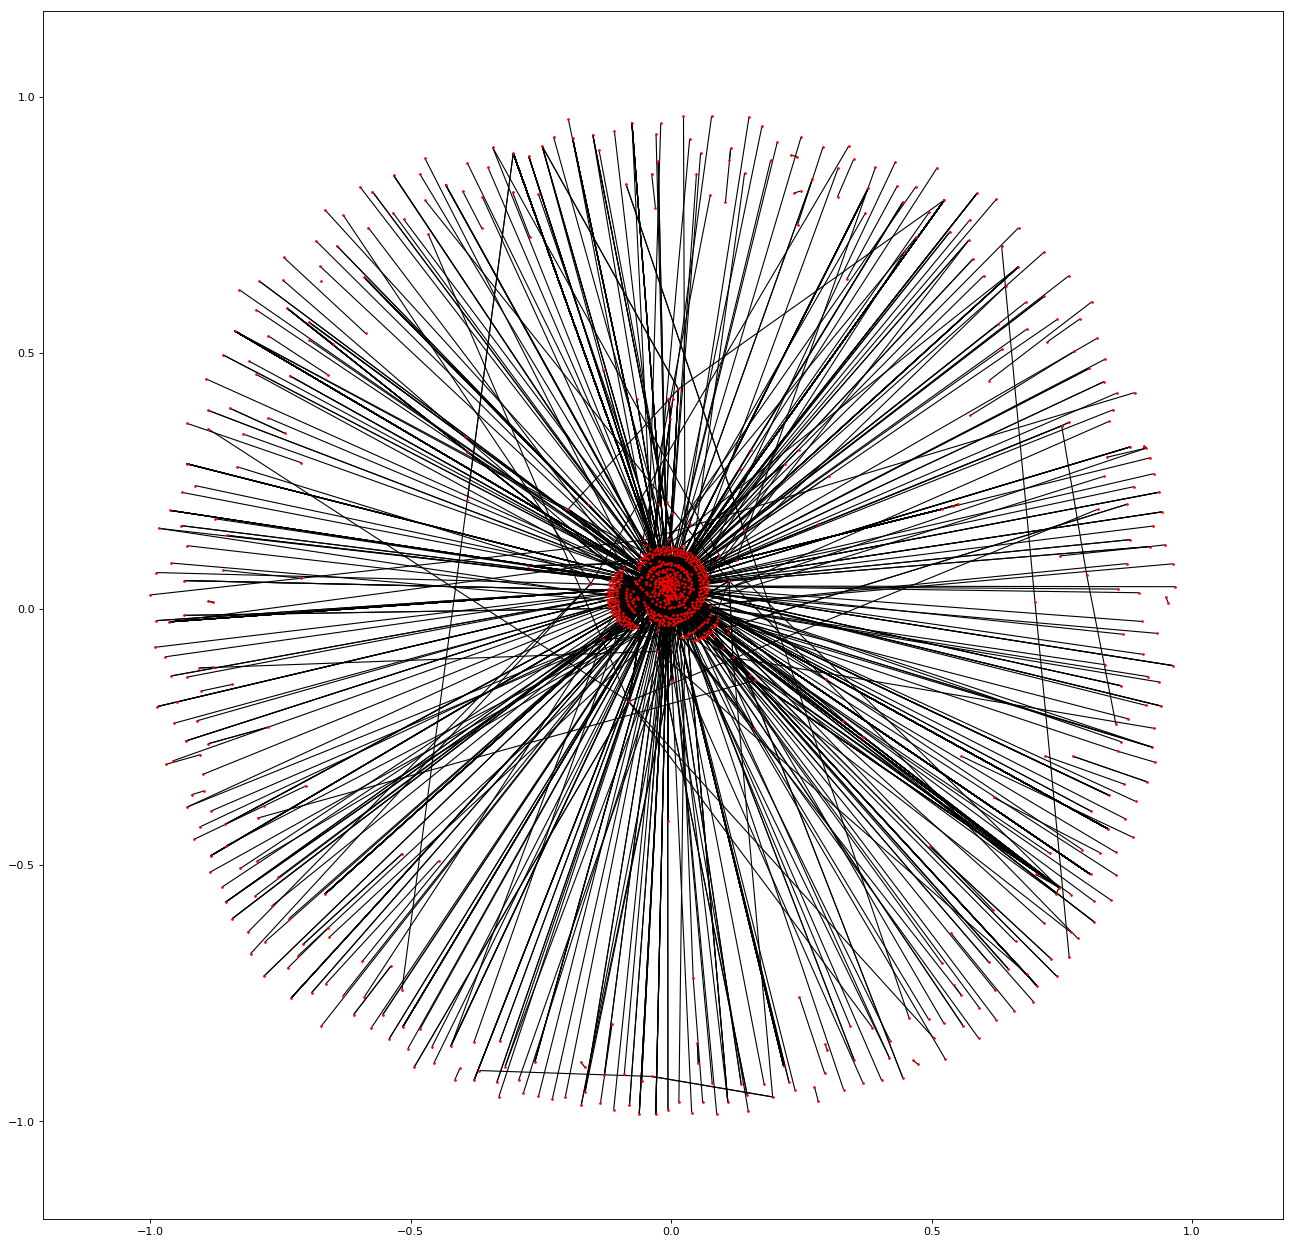

In [11]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
fig = plt.figure(1)
pos = nx.spring_layout(G)
d = nx.degree(G)
nx.draw_networkx_nodes(G,pos,arrows=False,node_size=2)
nx.draw_networkx_edges(G,pos,arrows=False)
plt.show()

#Quick code to save the graph aswell
from matplotlib import pylab
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(G,"my_graph.pdf")

In [12]:
#Code that exports graph to JSON in case i want to visualize it using D3.js
for n in G:
    G.nodes[n]['name'] = n
# write json formatted data
d = json_graph.node_link_data(G)  # node-link format to serialize
# write json
json.dump(d, open('graph.json', 'w'))

This network looks quite messy, and i don't think this is the right model for further analysis. Yet we still gained some insights by seeing who sends and receives the most mail by looking at the degree centrality. Let's look at more structured and simple approach

# Create the Network as a non-directed weighted graph

Another approach, which will be the primary network for analysis is the non-directed weighted graph where nodes only have one weighted link if they had communication. The weight is the total amount of mails send between the nodes. As we will see, this network looks better visually, and there is a more clear separation of nodes. Because the network is no longer directed, we can say something more general about the network and its communities. The network will be visualized with node size being scaled on degree and edge width being log-scaled on number of edges. We need to log-scale otherwise the network will look very disproportionate. 


In [13]:
# Initialize the Counter and Graph elements
counter = Counter()
G = nx.Graph()

# To avoid doing n^2 searching for nodes which we have already counted, we add them to a unique set which is smaller to search
uniq_nodes = set()

# search the data for "senders"
for mail in data:
    sender = mail["from"]
    receivers = []
    
    # No reason in checking nodes we already checked
    if(sender in uniq_nodes or sender == ""):
        continue
    # For each mail in the dataset, count the number of other nodes mail has been sent to
    for mail in data:
        if(sender == mail["from"] and mail["to"] != ""):
            receivers.append(mail["to"])
            
    
    receivers = Counter(receivers).most_common(1000)
    uniq_nodes.add(sender)
    
    for receiver in receivers:
        G.add_edge(sender,receiver[0],weight=math.log(receiver[1])+0.2)

print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of Edges: {}".format(G.number_of_edges()))


Number of nodes: 899
Number of Edges: 1128


Because of errors in the way data has been extracted some nodes have no connections to the rest of the graph. This is because of errors in the way the aliases has been constructed. To mitigate this we will work on the largest connected subgraph, or the GCC (Giant Connected Component). We will now plot the GCC with the node size and weights visualized appropriately 

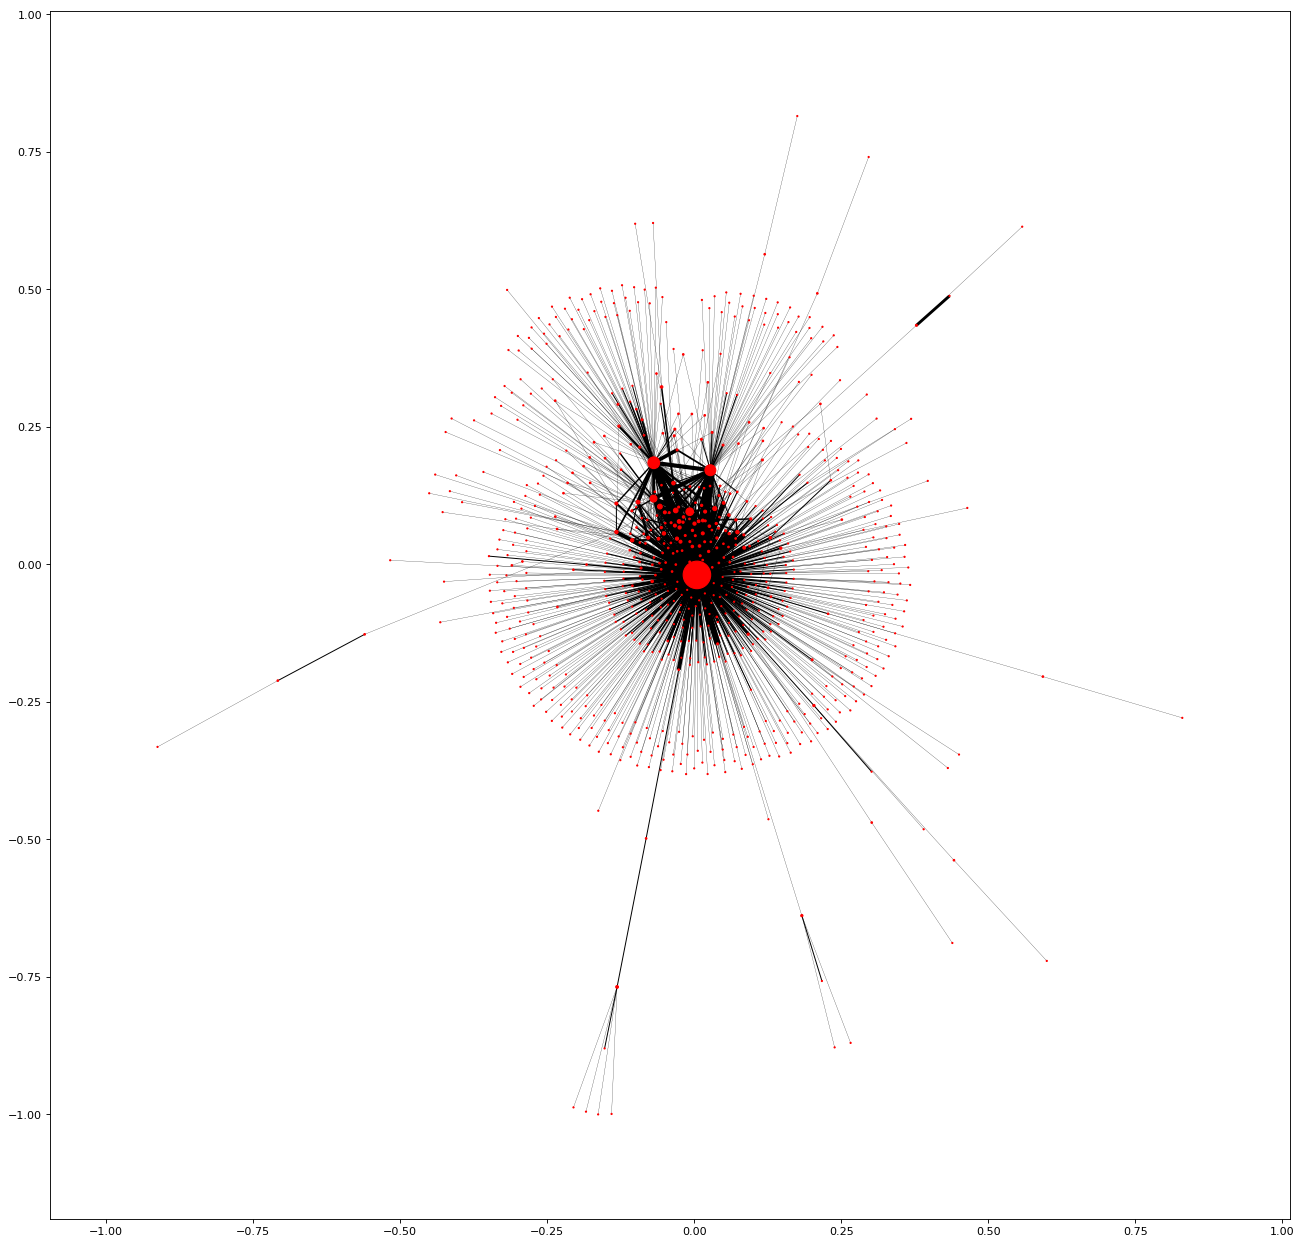

In [14]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
fig = plt.figure(1)

giant = max(nx.connected_component_subgraphs(G), key=len)
weights = [G[u][v]['weight'] for u,v in giant.edges]

pos = nx.spring_layout(giant,iterations=100)
d = nx.degree(giant)
# Find the degrees
degree_vals = [v[1] for v in d]

nx.draw_networkx_nodes(giant,pos,node_size=degree_vals)
nx.draw_networkx_edges(giant,pos,width=weights)
plt.show()

Max Degree 632
Min_Degree 21


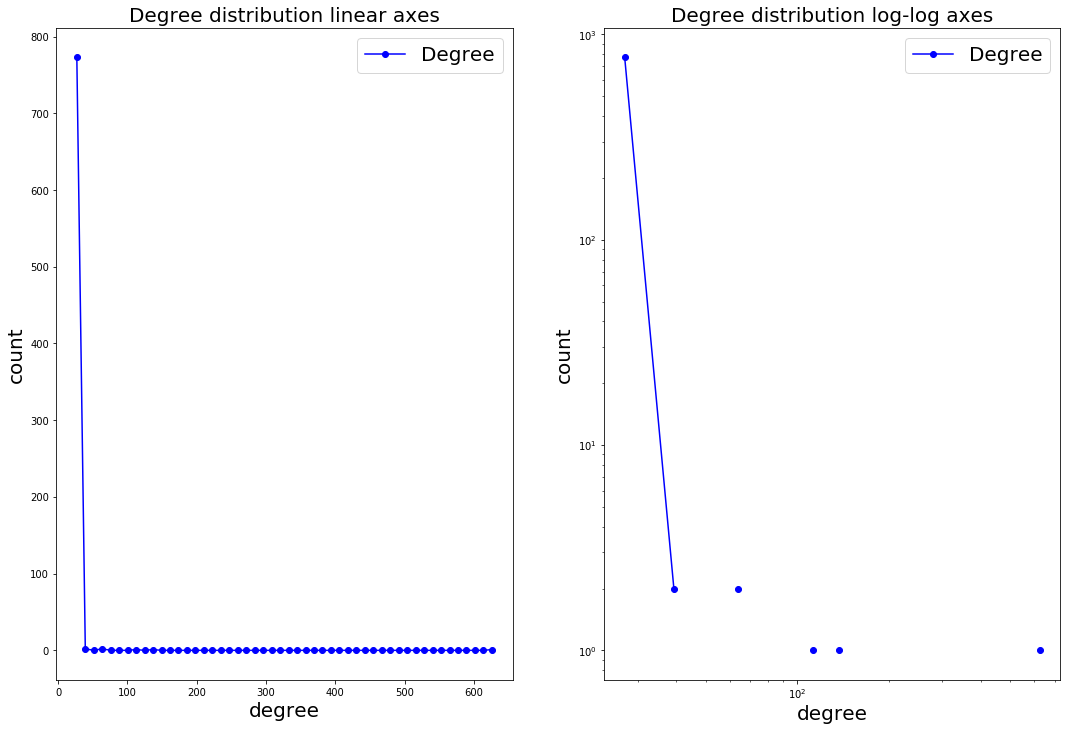

In [38]:
min_deg = min(degree_vals)
max_deg = max(degree_vals)

print("Max Degree",max_deg)
print("Min_Degree",min_deg)

# Bin the degree distributions
n = 50
bins = np.histogram(degree_vals, bins=n)

# Find the centers for each bin
bin_centers = []
for i in range(len(bins[1])-1):
    center = (bins[1][i]+bins[1][i+1])/2
    bin_centers.append(center)
    
# Plot degree distributions with linear axis and log axis
plt.figure(figsize=(18, 12))

plt.subplot(121)
line,=plt.plot(bin_centers, bins[0], 'bo-', label='Degree')
#plt.axis([0, 100, -25, max(bins)+50])
plt.xlabel('degree',fontsize=20)
plt.ylabel('count',fontsize=20)
plt.title('Degree distribution linear axes',fontsize=20)
plt.legend(handles=[line],fontsize=20)

plt.subplot(122)
linelog,=plt.loglog(bin_centers, bins[0], 'bo-', label='Degree')
plt.xlabel('degree',fontsize=20)
plt.ylabel('count',fontsize=20)
plt.title('Degree distribution log-log axes',fontsize=20)
plt.legend(handles=[linelog],fontsize=20)

#plt.savefig('deg_dist.png')
plt.show()


## Centrality Measures
Who are the most central persons in the network, indicators of centrality can help us answer this question. We will now try to identify the most influential nodes in the network using various metrics. 

### Degree Centrality
The degree centrality measure is simply the degree for each node. The most popular people in the network based on this measure is calculated by sorting the networkX degree list 

In [16]:
popular = list(d)

popular.sort(key=lambda x: x[1],reverse=True)

print("Persons with the highest degree\n")
for person in popular[0:10]:
    print(person)

Persons with the highest degree

('Hillary Clinton', 612)
('Huma Abedin', 111)
('Cheryl Mills', 96)
('Jacob Sullivan', 47)
('hrod17@clintonemail.com', 38)
('McHale, Judith A', 18)
('Monica Hanley', 17)
('Slaughter, Anne-Marie', 13)
('H2', 11)
('Valmoro, Lona J', 11)


We see that Hillary Clint is also the most central person also by this measure, again not really surprising. What is surprising is that Lauren Jiloty, number 4 in amount of mails sent from the previous network, is not even in top 10 for degree for this network. This suggests that this might be a better graph for detecting centrality as it detects how many different people has been emailed.  

### Betweenness centrality
The betweenness centrality of a node is a measure of centrality based on shortest paths. A nodes betweenness centrality score is the fraction of the shortest paths in the network that goes through it.

In [17]:
between_cent = nx.betweenness_centrality(giant)
popular = Counter(between_cent).most_common(10)

print("Highest betweenness centrality scores\n")
for person in popular:
    print(person)

Highest betweenness centrality scores

('Hillary Clinton', 0.9213139169624374)
('Huma Abedin', 0.1260751504541398)
('Cheryl Mills', 0.09483854766247263)
('hrod17@clintonemail.com', 0.019410636546012144)
('Donilon, Thomas E', 0.017833158983734335)
('Jacob Sullivan', 0.017463092614814744)
('Heintz, Stephen B', 0.015305364797660965)
('Diane Reynolds', 0.014371351245611976)
('McHale, Judith A', 0.013459851185199406)
('Obama, Barack', 0.012803970550867733)


### Eigenvector centrality

Eigenvector centrality is a measure of the influence a node has in a network. High scores are given to nodes who are relatively connected to other nodes of high scores. Nodes that are tightly connected will have a high centrality score, and outlying nodes will score low.

In [62]:
eigen_cent = nx.eigenvector_centrality(giant)
popular = Counter(eigen_cent).most_common(10)

print("Highest Eigenvector centrality scores\n")
for person in popular:
    print(person)

Highest Eigenvector centrality scores

('Hillary Clinton', 0.6870492710314828)
('Huma Abedin', 0.12887526046209732)
('Cheryl Mills', 0.12802896537126332)
('Jacob Sullivan', 0.09481139425699894)
('Monica Hanley', 0.054242411152510765)
('McHale, Judith A', 0.05250970969212107)
('Valmoro, Lona J', 0.050864158875282464)
('hrod17@clintonemail.com', 0.04846271172434458)
('Slaughter, Anne-Marie', 0.04839088266686127)
('Reines, Philippe I', 0.04551163872843863)


### Closeness centrality

Closeness centrality is the sum of the length of the shortest paths between that node and every other node. A central node will have a high closeness score, as you can get easily to all other nodes.

In [19]:
close_cent = nx.closeness_centrality(giant)
popular = Counter(close_cent).most_common(10)

print("Highest closeness centrality scores\n")
for person in popular:
    print(person)

Highest closeness centrality scores

('Hillary Clinton', 0.7940876656472987)
('Huma Abedin', 0.5148711169861203)
('Cheryl Mills', 0.5094833224329627)
('Jacob Sullivan', 0.49086326402016384)
('Monica Hanley', 0.47674418604651164)
('McHale, Judith A', 0.47528981086028066)
('Slaughter, Anne-Marie', 0.4738442822384428)
('Valmoro, Lona J', 0.4738442822384428)
('Diane Reynolds', 0.4729811778992107)
('Lauren Jiloty', 0.4724075197089145)


So we gathered a bunch of measures for different centralities. Now let's look at the community detection. We will calculate the best community partition using the Python-Louvain algorithm.

# Python-Louvain Community

In [63]:
# Compute a partitioning of the network using the Python-louvain algorithm which
# is imported with "community"
louvain_partition = community.best_partition(giant)

n = max([x[1] for x in louvain_partition.items()])+1
print("Number of communities found by the Python-Louvain: %d " % n)

Number of communities found by the Python-Louvain: 17 


With the partitioning done, we can assign nodes to their corresponding community, and gather some statistics about community size. We will also be able to plot the communities by assigning a unique color to them. In the end it will be interesting to use the community partitioning to generate some topics. Do certain communities discuss certain matters?

Lets see if we can figure out what theese communities look like.

In [21]:
# How many are in each community?
partitions = [set() for i in range(n)]

for person in louvain_partition:
    partitions[louvain_partition[person]].add(person)

#Length of the partitions
count = 0
for partition in partitions:
    count+=1
    print("Length of partition #%d: %d"%(count,len(partition)))

Length of partition #1: 94
Length of partition #2: 532
Length of partition #3: 93
Length of partition #4: 10
Length of partition #5: 3
Length of partition #6: 10
Length of partition #7: 4
Length of partition #8: 2
Length of partition #9: 3
Length of partition #10: 5
Length of partition #11: 3
Length of partition #12: 4
Length of partition #13: 8
Length of partition #14: 2
Length of partition #15: 3
Length of partition #16: 2
Length of partition #17: 2


A few of the partitions are of relative big size, although we have some very minor communities. None of the communities are by themself, so that is good. Let's explore where the top 5 persons (By degree centrality) are located, are they in the same community? Are they in the biggest community?


In [22]:
popular = list(d)
popular.sort(key=lambda x: x[1],reverse=True)
top10 = [p[0] for p in popular[:10]]

print("The top 10 by degree centrality")
print(top10)
print("What community does the top 10 belong to \n")
part_num = 0
for partition in partitions:
    for person in top10:
        if(person in partition):
            print("%s was in community: %d. Community has size %d" % (person,part_num,len(partition)))
    part_num+=1

The top 10 by degree centrality
['Hillary Clinton', 'Huma Abedin', 'Cheryl Mills', 'Jacob Sullivan', 'hrod17@clintonemail.com', 'McHale, Judith A', 'Monica Hanley', 'Slaughter, Anne-Marie', 'H2', 'Valmoro, Lona J']
What community does the top 10 belong to 

Huma Abedin was in community: 0. Community has size 94
Monica Hanley was in community: 0. Community has size 94
H2 was in community: 0. Community has size 94
Valmoro, Lona J was in community: 0. Community has size 94
Hillary Clinton was in community: 1. Community has size 532
Cheryl Mills was in community: 2. Community has size 93
Jacob Sullivan was in community: 2. Community has size 93
hrod17@clintonemail.com was in community: 2. Community has size 93
Slaughter, Anne-Marie was in community: 2. Community has size 93
McHale, Judith A was in community: 3. Community has size 10


So interestingly enough Hillary Clinton is not in the same community as her closest advisors! She is in the largest community. Huma Abedin, being the most central node next to Hillary is in her own community aswell, and Cheryl Mills, Jacob Sullivan and hrod17 are all in the same community.

This is very interesting, as it might hint at an underlying structure in the network. 

Now how does the network look after the partitition has been colored in, can we see a clear distinction between different areas of the network?

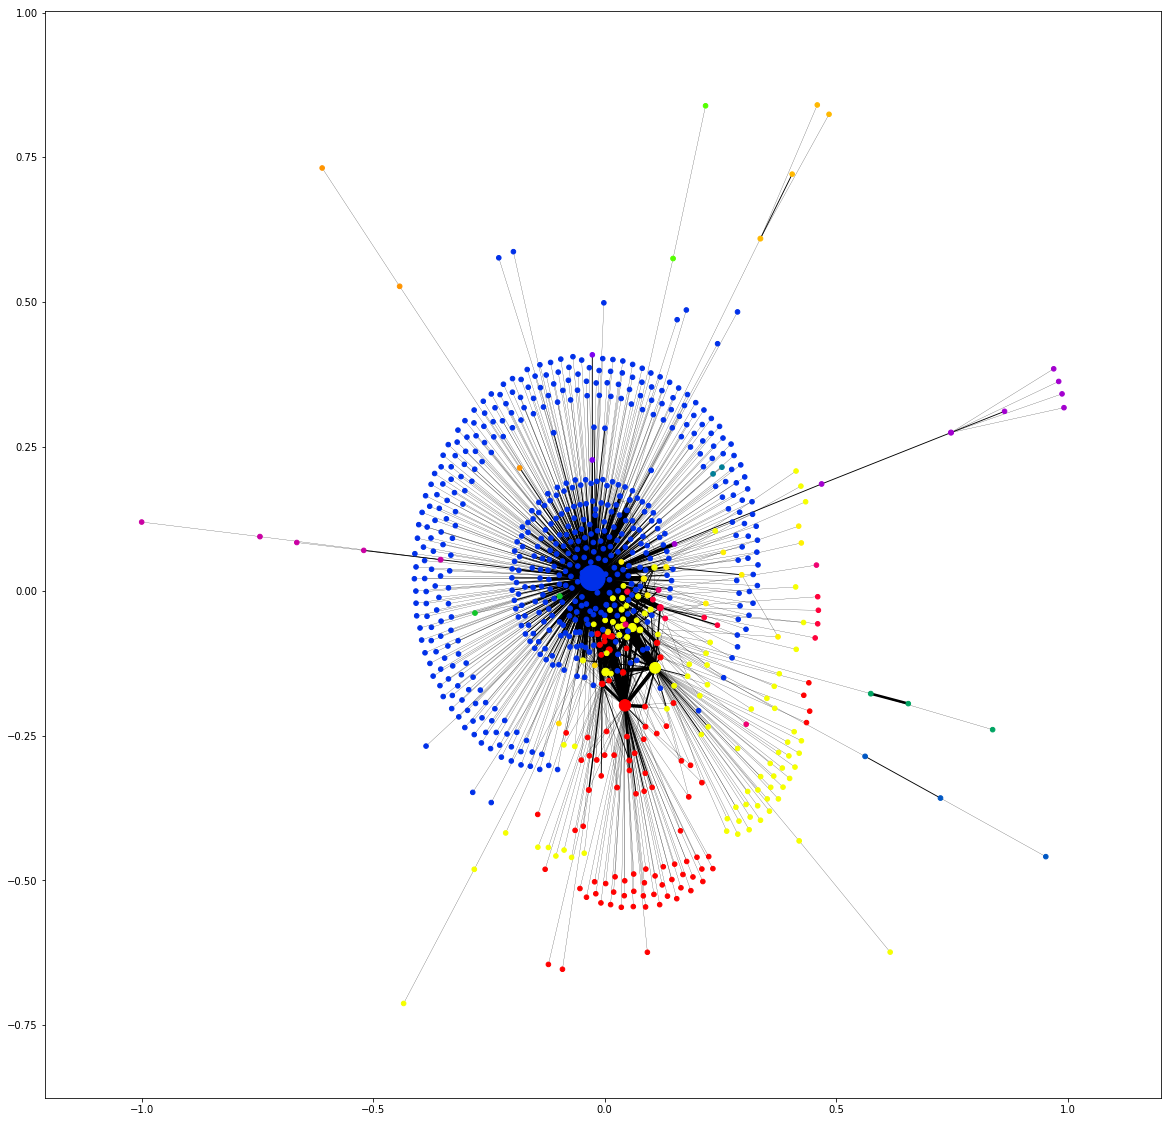

In [23]:
values = [louvain_partition.get(node) for node in giant.nodes()]
weights = [G[u][v]['weight'] for u,v in giant.edges]
pos = nx.spring_layout(giant,iterations=250)

d = nx.degree(giant)
# Find the degrees
degree_vals = [v[1]+20 for v in d]

plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(giant,pos,node_size=degree_vals,node_color=values,cmap=plt.get_cmap('prism'))
nx.draw_networkx_edges(giant,pos,width=weights)

plt.show()


Having toyed around with some different pyplot colormaps ('jet','prism_r','rainbow') i decided to use 'prism'. I am very happy with the communities that the Python-Louvain algorithm has found, as they are clearly seen in the graph above. Some observations right off is that the largest community, the blue one, is the one Hillary Clinton is in. Most of these nodes have very low edge weight, which leads me to conclude these are incoming mails that never was replied by the Secretary, these are all put in the same community.

Another observation, which we saw from the persons in each community, is that Huma Abedin and Monica Hanley are in the same community, and that Cheryl Mills and Jacob Sullivan is in another. 

Huma Abedin is deputy chief of staff, and Monica Hanley is a "confidential assistant". Apparently the people these two central figures correspond with are in the same community.

Chief of Staff Cheryl Mills and former Director of Policy Planning Jake Sullivan are in the same community. They fall within the same community. Considering Huma Abedin and Cheryl Mills are Deputy Chief of staff and Chief of staff it is odd they are not in the same community, maybe they were in charge of different groups of people. 

Then we have some smaller communities with 2-10 people with a relative high edge weight which suggests a particular topic being discussed heavily between few people. Interesting!


# Part 4: Natural Language Processing and Analysis

Now let's look at what the most central people talk about in their mails, what about the communities? And finally, let's see if we can figure out key real world events from email density and topic extraction. Will we find out the deep dark secrets of these leaked documents?

Data has been previously parsed and scrubbed from the PDF files for each mail and saved into the dictionary. With this data we can generate the TF-IDF statistic. First we construct the Inverse Document Frequency list over all mails to see how rare words are. Then for each mail or collection of mails we can use the Term Frequency against the Inverse Document Frequency to get a measure for which words in that collation of documents are important. 

We will use this strategy to find topics in collection of emails. A collection could be a community, a person, a set of persons or a time-period. We can group the mails any way we want, to gather a set of topic words for that collection. We will try that now. 

In [24]:
import nltk
from nltk.corpus import stopwords
import string
import math
from wordcloud import WordCloud

For later use, let's combine a text corpus of the emails sent for the top 10 most popular persons in the network. 

In [25]:
#Combine the email text for the 10 most popular people into a large corpus for TF-IDF and Topic Extraction
print(popular_out.keys())
for mail in data:
    if(mail["to"] == None):
        mail["to"] = ""
    if(mail["from"] == None):
        mail["from"] = ""
    To = str.lower(mail["to"])
    From = str.lower(mail["from"])
    if(To in popular_out.keys()):
        popular_out[To]["corpus"] += mail["extractedContent"]
    if(From in popular_in.keys()):
        popular_in[From]["corpus"] += mail["extractedContent"]

dict_keys(['hillary clinton', 'huma abedin', 'cheryl mills', 'jacob sullivan', 'lauren jiloty', 'monica hanley', 'sbwhoeop', 'valmoro, lona j', 'slaughter, anne-marie', 'coleman, claire l'])


Now we use the TF-IDF method from the Scikit-learn python package, as it makes everything a little bit faster and easier for us to compute. For decomposition i will be using the Non-Negative Matrix Factorization (NMF) decomposition method. It proves to be excellent for topic extraction as it reduces the dimensionality of a dataset (Lots of words, down to a smaller set of words while maintaining accuracy). This smaller set of words is our topic.

In [26]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups

# Number of NMF samples and features
n_samples = 20000
n_features = 10000
# Number of topics, with decreasing accuracy, to extract
n_components = 5
# How many words to return for the topic
n_top_words = 50

# Prints the top words for the topic returned by the NMF model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print("\n")

# For this example we take ALL the emails from the dataset, and create a few 
# topics, this should create some broad and general topics.
corpus = [mail["extractedContent"] for mail in data]

# Use tf-idf features for NMF, remove english stopwords
print("Extracting tf-idf features...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)

# Fit the Non-negative Matrix Factorization
# The Kullback-leibler loss seemed to work quite well
print("Fitting the NMF model...")
nmf = NMF(n_components=n_components,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

print("\nTopics found:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Extracting tf-idf features...
Fitting the NMF model...

Topics found:
Topic #0: fyi sbu importance high message traffic latest interesting b6 headers forwarded posted cdm reason b1 worth jm highlight wi jeffrey sensitive scroll sigh hbj reading ni yup wjc context declassify paul prior speaking referring fred feltman announced todd schumer begin update version quartet rick farmer addressing case denis piece troubling


Topic #1: print pls pis respond tell list send ask letter add note hrc come copy response rob draft schedule original bring asap oscar sign review email sent prepare article updated today copies book printing did sure melanne perfect memcon printed steinberg rec sid huma marina necessary tomorrow address version johnnie ops


Topic #2: ok thx tomorrow talk time ops tonight 30 today sheet calling like ll morning secure later set follow want home minutes let works leave ready 10 need house fine wants speak confirmed plane office just available phone connect meeting schedule

Now with a few topics generated for the entire mail corpus, we can visualize it using the IDF. Using the Wordcloud package, we input a list of words, where every word is repeated for each time it occurs in the IDF. This way words that are repeated a lot will have bigger font in the Wordcloud. Lets visualize the 5 topics we just found for the entire mail corpus

Topic #0: 
fyi 3.674222995
sbu 5.72267075886
importance 6.02495163074
high 5.45696759313
message 5.51503139409
traffic 6.5555798818
latest 6.00257933298
interesting 6.5555798818
b6 5.12969505341
headers 7.27997960586

Topic #1: 
print 4.57510905768
pls 4.44957131274
pis 5.10054909233
respond 6.10499433841
tell 5.6995292303
list 5.76015385212
send 5.23690570835
ask 5.66737211867
letter 5.89368524474

Topic #2: 
ok 4.49850193621
thx 4.91583661987
tomorrow 4.46943012138
talk 4.91285599173
time 3.98767631244
ops 5.51231768821
tonight 5.73953456492
30 4.62517391928

Topic #3: 
state 4.00193680366
secretary 4.12264151799
meeting 4.36263796626
10 4.47613834012
time 3.98767631244
office 4.47421710994
department 4.56981523907

Topic #4: 
yes 4.87346359002
just 4.13213955411
know 4.23168500222
b5 4.95231482847
thanks 4.96477604891
good 4.58900559344



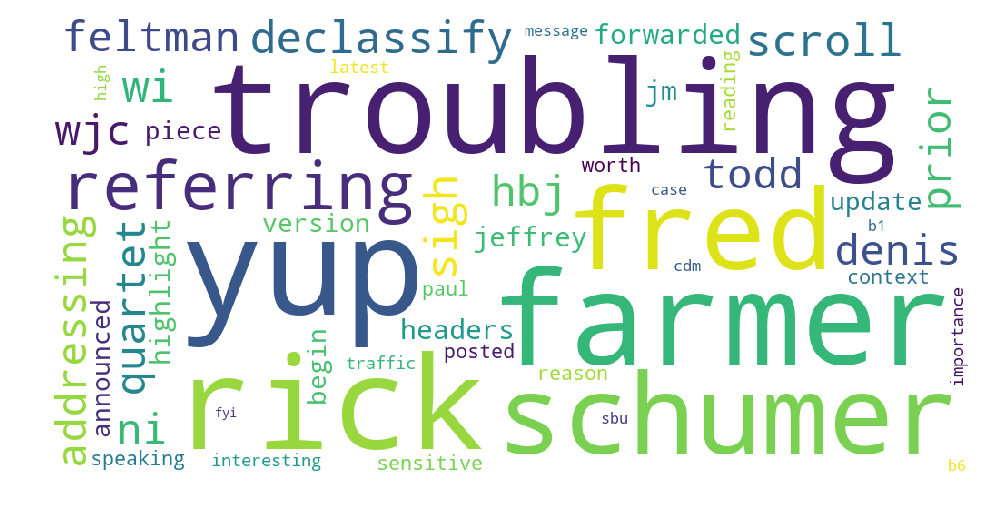

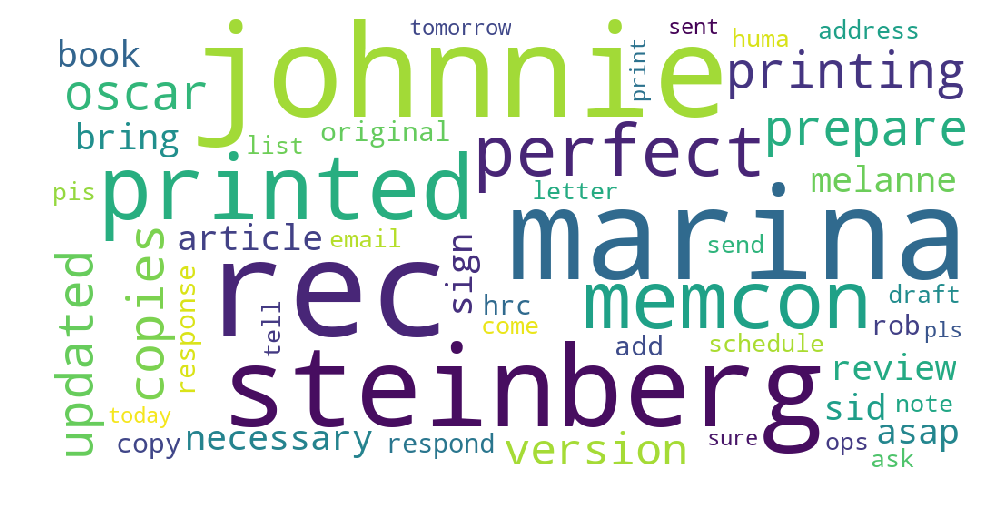

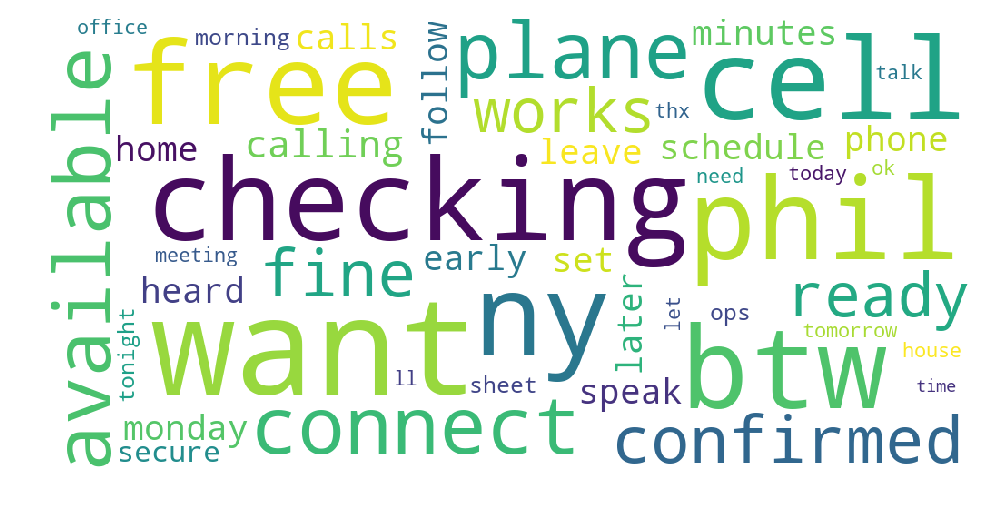

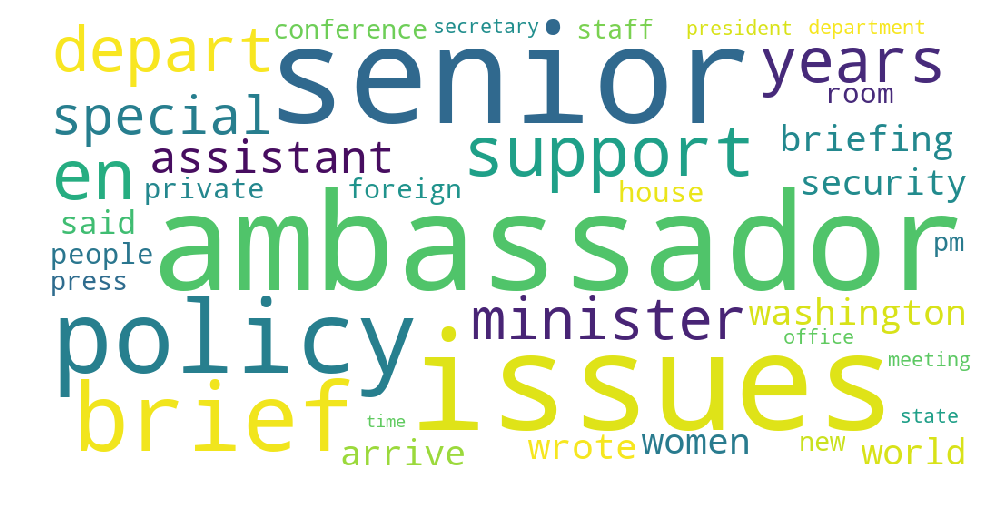

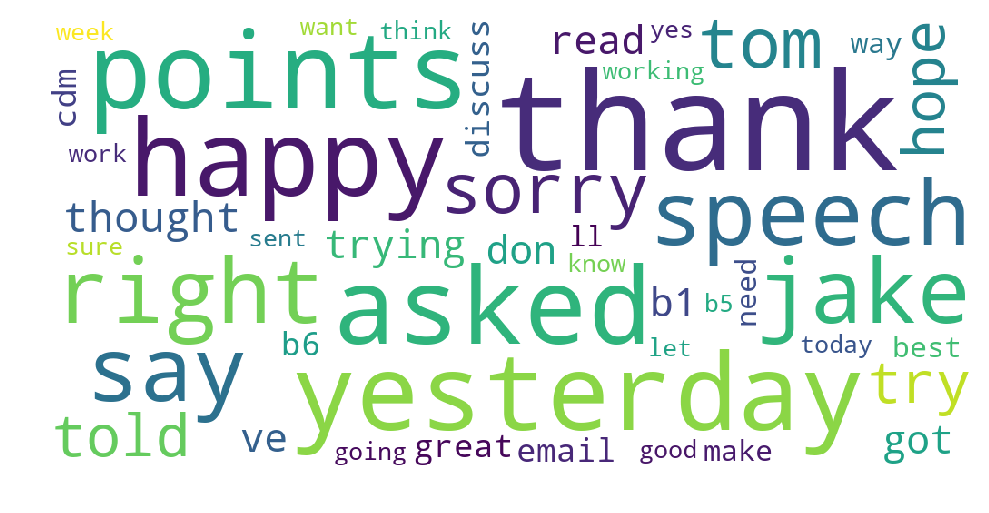

In [27]:
model = nmf
feature_names = tfidf_vectorizer.get_feature_names()
idf = tfidf_vectorizer.idf_

topics = []

#Print a few messages their weights, to see how important they are in the IDF
print_count = 10
for topic_idx, topic in enumerate(model.components_):
    message = "Topic #%d: \n" % topic_idx
    message += "".join([feature_names[i] + " " + str(idf[i]) + "\n"
                         for i in topic.argsort()[:-print_count - 1:-1]])
    
    print(message)
    print_count+=-1
    text = ""
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        for j in range(int(idf[i])):
            text = feature_names[i] + " " + text
    
    topics.append(text)
    
for topic_idx,topic in enumerate(topics):

    # Generate a word cloud image
    wordcloud = WordCloud().generate(topic)

    # Display the generated image:
    # the matplotlib way:
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(max_font_size=150,width=1024,height=512,
                          background_color='white',collocations=False,margin=10).generate(topic)
    plt.figure(figsize=(12, 12),dpi=100)
    plt.imshow(wordcloud)
    plt.axis("off")

    pic_name = 'entire_'+str(topic_idx)+'.png'
    plt.savefig(pic_name)

    plt.show()

These wordclouds represents various decompositions of the entire email corpus. We have topic \#4 concerning "government" "gov" "issues" "policy" and "minister" and then we have topic \#2 that is mostly words like "printed" "copies" "draft" "paper" and "prepare". So a bit of different expressions for the email corpus. Alot of printing is apparently going on in the White House, we'll get back into that later. 

Now we will simply do the same thing, but for different collections of corpusses. 

## Popular Persons Topic Extraction

Extracting tf-idf features for NMF...
done in 0.080s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.177s.

Topics in NMF model for: hillary clinton


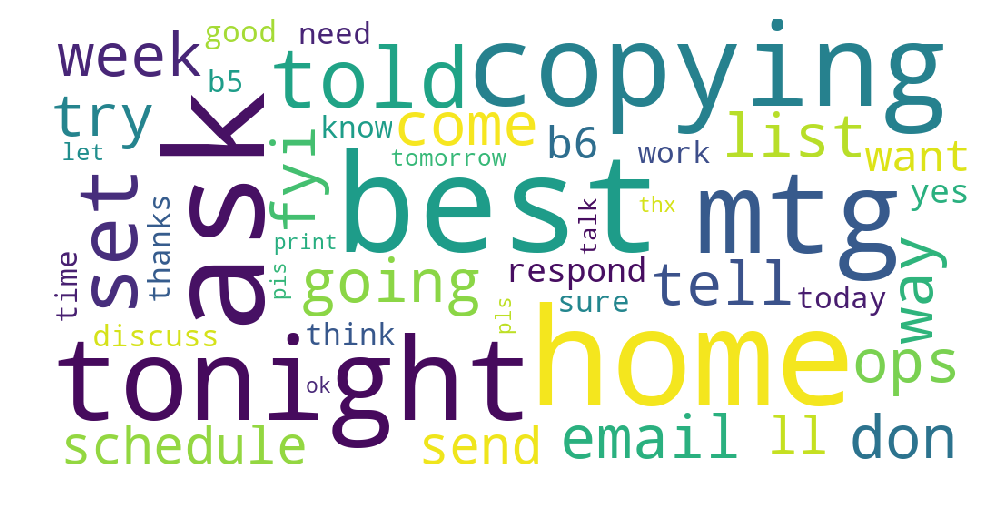

Extracting tf-idf features for NMF...
done in 0.054s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.107s.

Topics in NMF model for: huma abedin


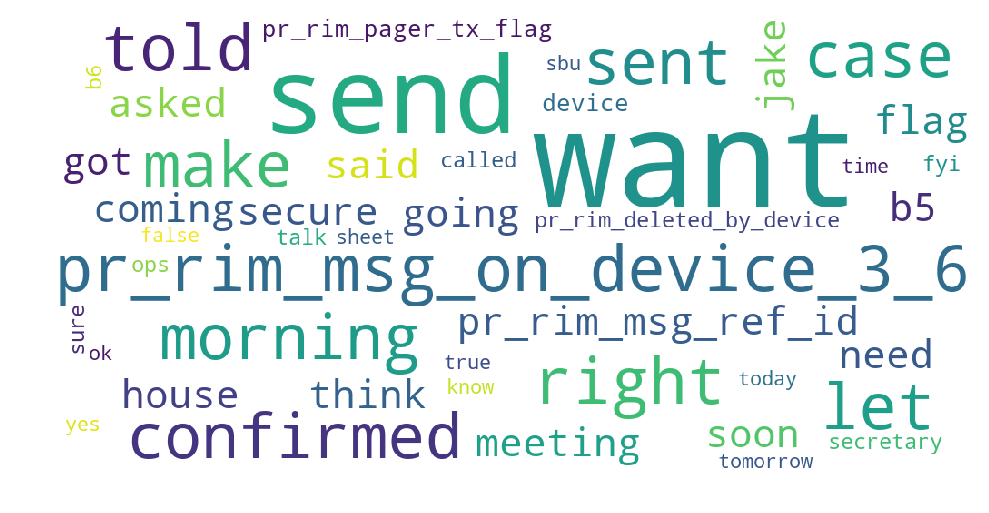

Extracting tf-idf features for NMF...
done in 0.048s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.088s.

Topics in NMF model for: cheryl mills


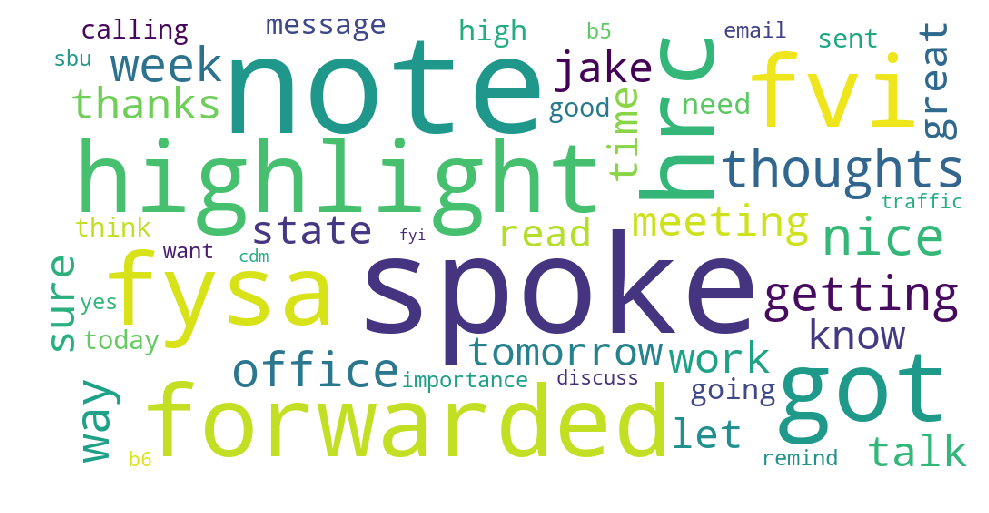

Extracting tf-idf features for NMF...
done in 0.085s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.188s.

Topics in NMF model for: jacob sullivan


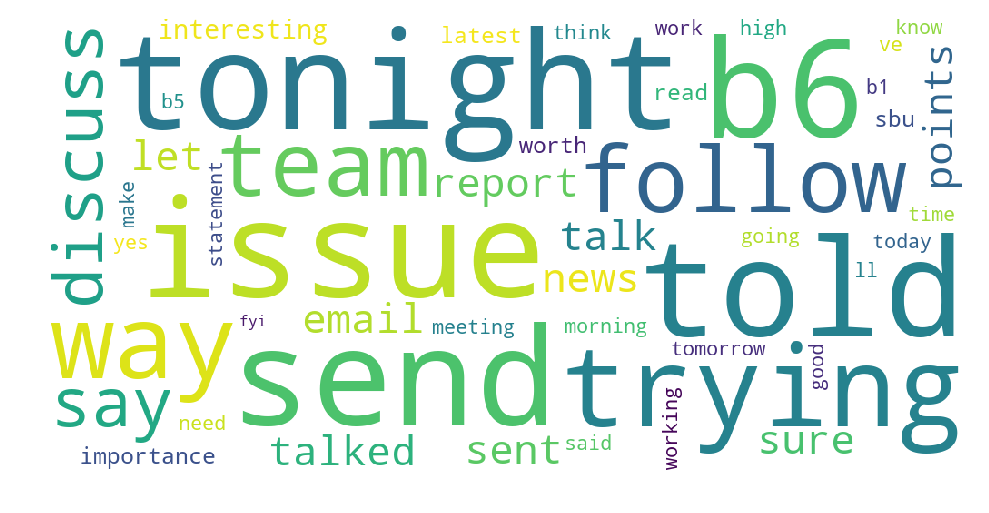

Extracting tf-idf features for NMF...
done in 0.047s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.102s.

Topics in NMF model for: lauren jiloty


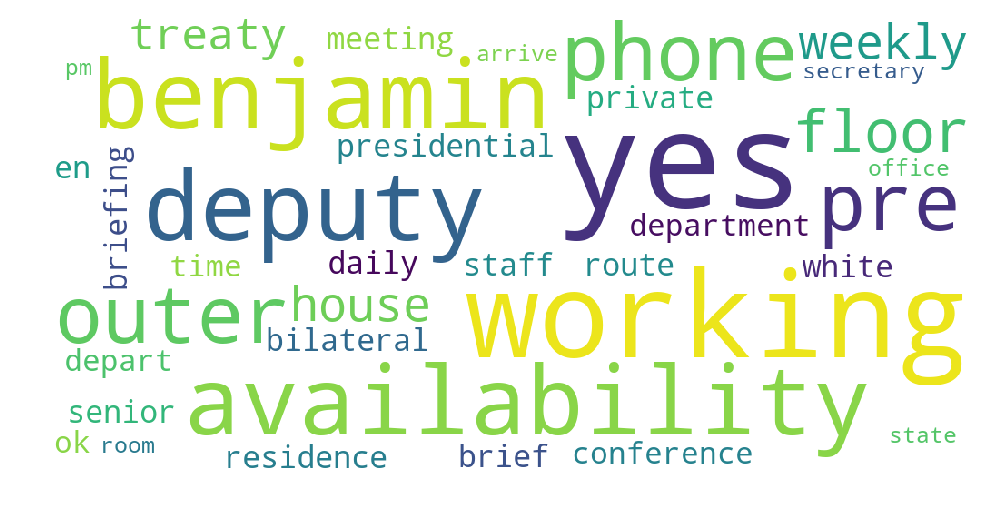

Extracting tf-idf features for NMF...
done in 0.017s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.039s.

Topics in NMF model for: monica hanley


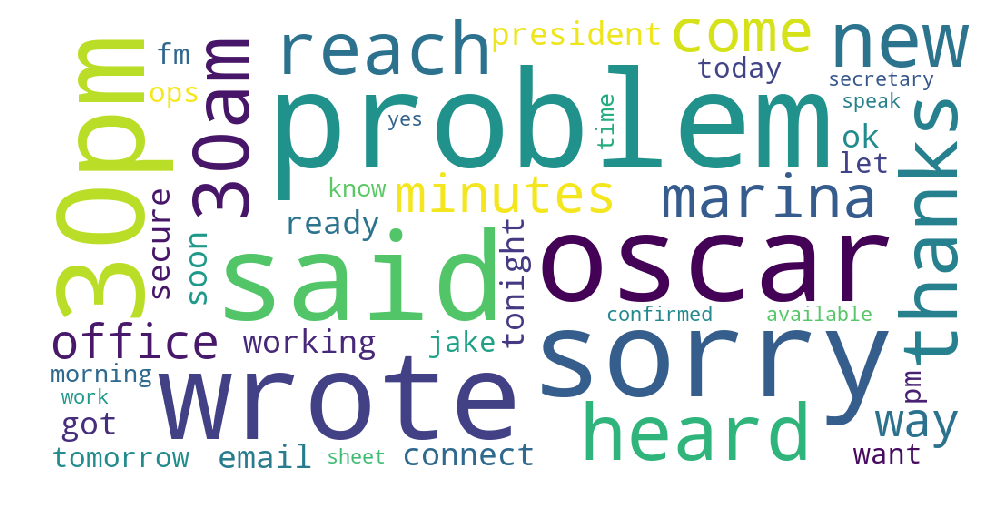

Extracting tf-idf features for NMF...
done in 0.054s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.097s.

Topics in NMF model for: sbwhoeop


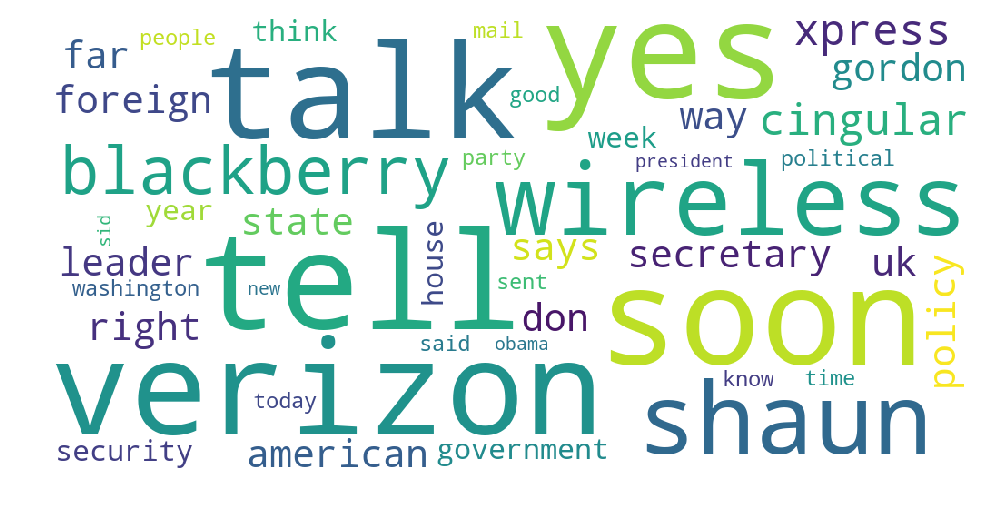

Extracting tf-idf features for NMF...
done in 0.013s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.037s.

Topics in NMF model for: valmoro, lona j


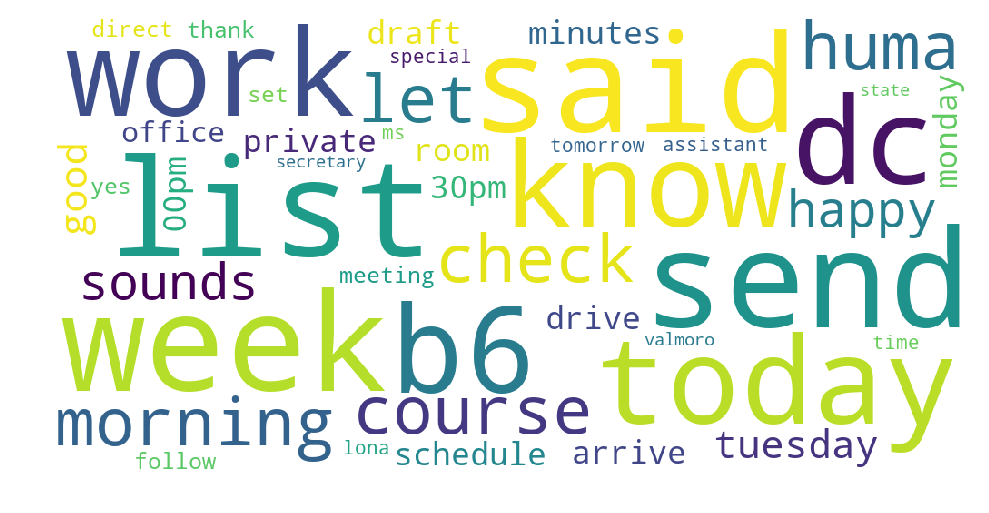

Extracting tf-idf features for NMF...
done in 0.035s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.069s.

Topics in NMF model for: slaughter, anne-marie


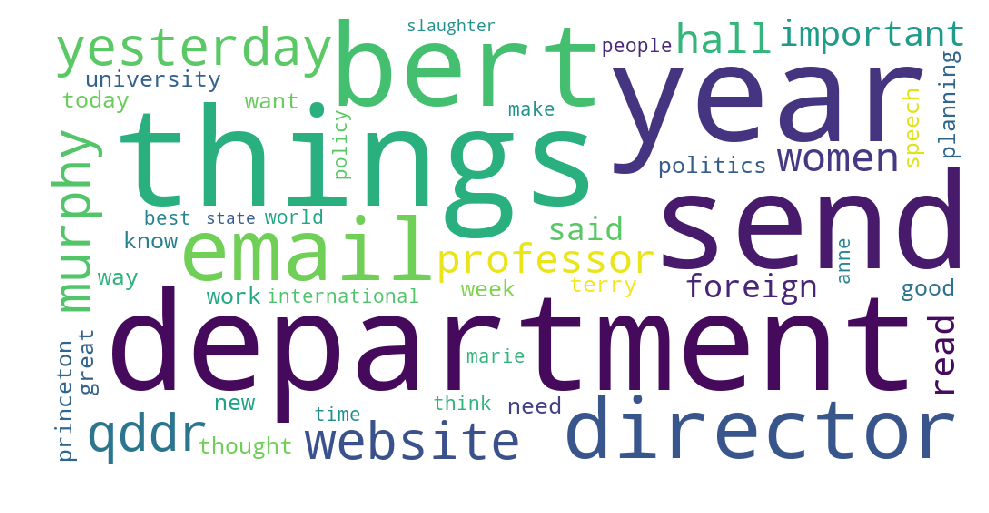

Extracting tf-idf features for NMF...
done in 0.023s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=20000 and n_features=10000...
done in 0.058s.

Topics in NMF model for: coleman, claire l


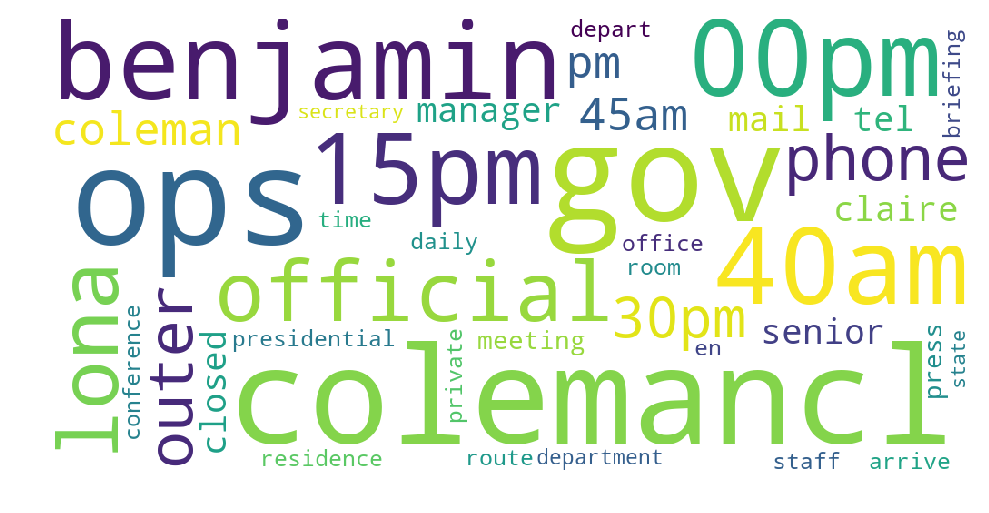

In [28]:
n_samples = 20000
n_features = 10000
n_components = 1
n_top_words = 50


for person in popular_out:
 
    topics = []
    t0 = time()

    data_samples = [mail["extractedContent"] for mail in data if str.lower(mail["from"]) == person]

    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))

    # Fit the NMF model
    print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
          "tf-idf features, n_samples=%d and n_features=%d..."
          % (n_samples, n_features))
    t0 = time()
    nmf = NMF(n_components=n_components, random_state=1,
              beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
              l1_ratio=.5).fit(tfidf)
    print("done in %0.3fs." % (time() - t0))

    print("\nTopics in NMF model for: " + person)
    model = nmf
    feature_names = tfidf_vectorizer.get_feature_names()
    idf = tfidf_vectorizer.idf_

    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: \n" % topic_idx
        message += "".join([feature_names[i] + " " + str(idf[i]) + "\n"
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        #print(message + "\n")

        text = ""
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            for j in range(int(idf[i])):
                text = feature_names[i] + " " + text

        topics.append(text)

    for topic_idx,topic in enumerate(topics):

        # Generate a word cloud image
        wordcloud = WordCloud().generate(topic)

        # Display the generated image:
        # the matplotlib way:
        # take relative word frequencies into account, lower max_font_size
        wordcloud = WordCloud(max_font_size=150,width=1024,height=512,
                              background_color='white',collocations=False,margin=10).generate(topic)
        plt.figure(figsize=(12, 12),dpi=100)
        plt.imshow(wordcloud)
        plt.axis("off")

        pic_name = 'popular_'+str(person).replace(" ","_")+"_"+str(topic_idx)+'.png'
        plt.savefig(pic_name)

        plt.show()


## Community TF-IDF 

And we can also do it for the 3 largest communities which we found earlier in the network analysis. Lets try to do that now!

First we gather the top 3 largest communities, then for each community we gather the emails for each person and append them to a list. This leaves us with three groups of strings, one for each community detected by the python Louvain. Next we will use the NMF topic extraction and wordcloud visualization exactly as previous

In [35]:
# How many are in each community?
partitions = [set() for i in range(n)]

for person in louvain_partition:
    partitions[louvain_partition[person]].add(person)

# Get the top 3 partitions for TF-IDF analysis
count = 0
top3_partitions = []
for partition in partitions:
    count+=1
    if(len(top3_partitions) < 3):
        top3_partitions.append(partition)
    
top3_partitions_corpus = []
count = 0
for partition in top3_partitions:
    top3_partitions_corpus.append({
        "topic": count,
        "nodes": len(partition),
        "corpus": []
    })
    for person in partition:
        for mail in data:
            if(mail["to"] == None):
                mail["to"] = ""
            if(mail["from"] == None):
                mail["from"] = ""
            if(mail["from"] == person):
                top3_partitions_corpus[count]["corpus"].append(mail["extractedContent"])
    count+=1
    

Extracting tf-idf features for NMF...
done in 0.120s.
Fitting the NMF model...
done in 0.280s.

Topics for Community 1 with 94 nodes: 


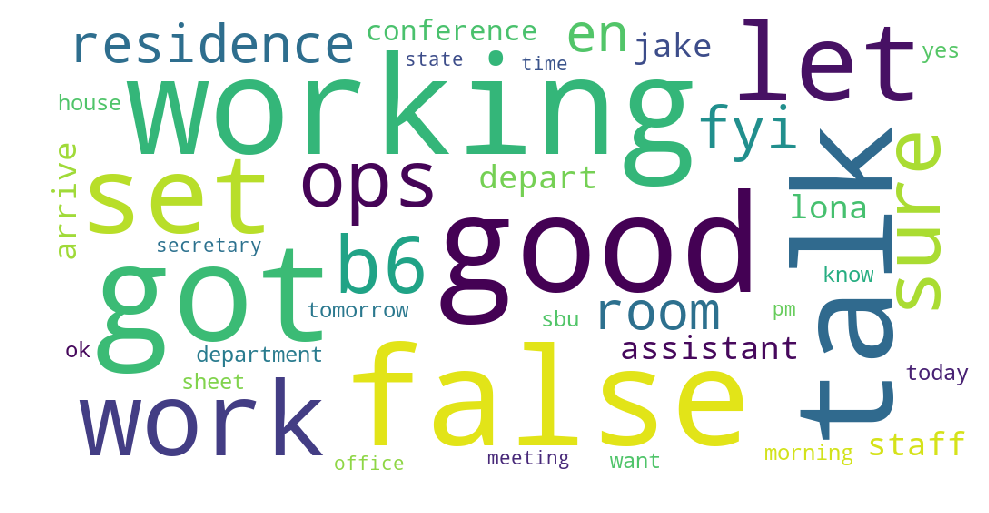

Extracting tf-idf features for NMF...
done in 0.204s.
Fitting the NMF model...
done in 0.548s.

Topics for Community 2 with 532 nodes: 


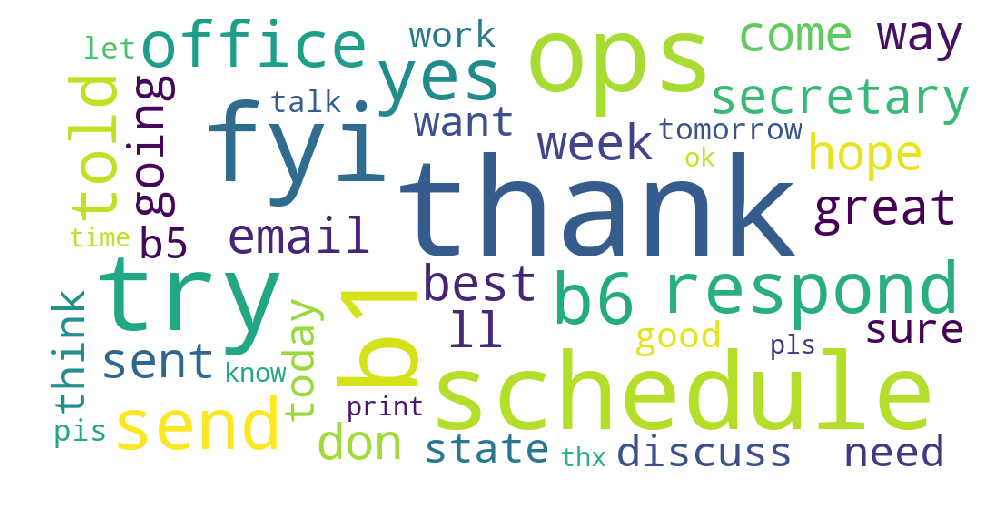

Extracting tf-idf features for NMF...
done in 0.212s.
Fitting the NMF model...
done in 0.591s.

Topics for Community 3 with 93 nodes: 


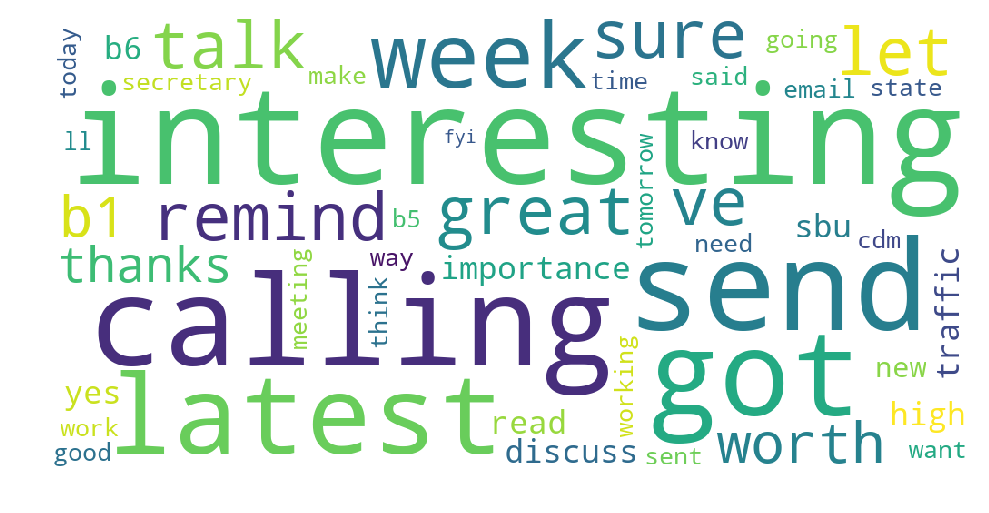

In [36]:
n_samples = 20000
n_features = 10000
n_components = 1
n_top_words = 50

count = 0
for corpus in top3_partitions_corpus:
 
    topics = []
    t0 = time()

    data_samples = corpus["corpus"]
    topic = corpus["topic"]
    nodes = corpus["nodes"]
    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))

    # Fit the NMF model
    print("Fitting the NMF model...")
    t0 = time()
    nmf = NMF(n_components=n_components, random_state=1,
              beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
              l1_ratio=.5).fit(tfidf)
    print("done in %0.3fs." % (time() - t0))

    print("\nTopics for Community %d with %d nodes: " % (topic+1,nodes))
    model = nmf
    feature_names = tfidf_vectorizer.get_feature_names()
    idf = tfidf_vectorizer.idf_

    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: \n" % topic_idx
        message += "".join([feature_names[i] + " " + str(idf[i]) + "\n"
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        #print(message + "\n")

        text = ""
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            for j in range(int(idf[i])):
                text = feature_names[i] + " " + text

        topics.append(text)

    for topic_idx,topic in enumerate(topics):

        # Generate a word cloud image
        wordcloud = WordCloud().generate(topic)

        # Display the generated image:
        # the matplotlib way:
        # take relative word frequencies into account, lower max_font_size
        wordcloud = WordCloud(max_font_size=150,width=1024,height=512,
                              background_color='white',collocations=False,margin=10).generate(topic)
        plt.figure(figsize=(12, 12),dpi=100)
        plt.imshow(wordcloud)
        plt.axis("off")

        pic_name = 'community_'+str(count)+'.png'
        plt.savefig(pic_name)

        plt.show()
    count+=1

Huma Abedin was in community: 0. Community has size 107
Monica Hanley was in community: 0. Community has size 107
H2 was in community: 0. Community has size 107
Hillary Clinton was in community: 1. Community has size 494
Cheryl Mills was in community: 2. Community has size 90
Jacob Sullivan was in community: 2. Community has size 90
hrod17@clintonemail.com was in community: 2. Community has size 90
McHale, Judith A was in community: 2. Community has size 90
Slaughter, Anne-Marie was in community: 2. Community has size 90
Secretary was in community: 3. Community has size 38

The first community contained Huma Abedin and Monica Hanley. This Wordcloud contains words like staff, room, assistant, meeting, department and confirmed. This corresponds well with their roles as Huma Abedin is Deputy Chief of Staff.

The second community contained Hillary Clinton. The words in this wordcloud are generally smaller and contains small requests like "pls" or "pis" (which is when the pdf extracter mistakes the l for an i) and print. Also the word "respond" is quite large, which is funny because Hillary receives three times as many mails as she responds to. 

The third community contained Cheryl Mills and Jacob Sullivan among others. It contains words like send, statement, calling, remind, read, latest among others. This suggests this community sends out statements and sets up meetings. Jacob Sullivans main job was to prepare Hillary for debates, and you can kind of see that in this third wordcloud.


# Email density over time
One last subject i want to explore is the email densitiy over time. I want to see if i can find one particular date in the dataset (I will refrain from doing more than one to spare you of more wordclouds) which stands out. A date where more mails has been sent and received than normal. 

Let's start by plotting the date distribution. The timestamps from FOIA was in UNIX time, so we need to format the axis to deal with that. Luckily the FuncFormatter from the ticker in matplotlib package helped me quite a bit.

Also we divide the day by 1000, as we are not interested in hours, minutes and seconds (Also they were not given by FOIA)

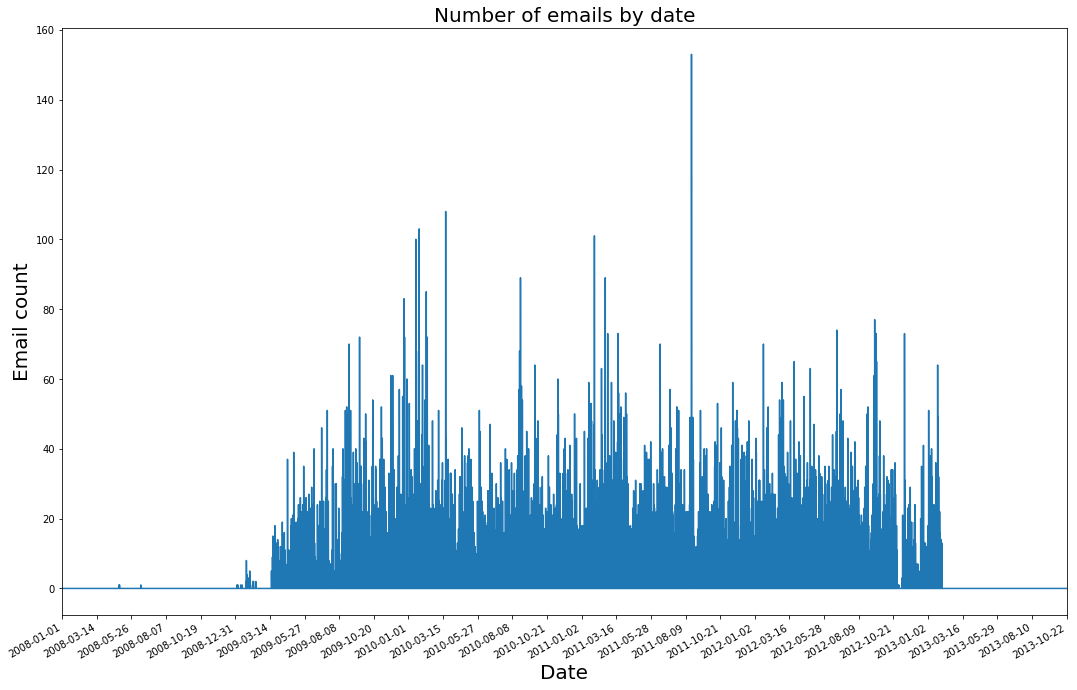

In [39]:
#Convert the weird Unix timestamps to python datetime.
import datetime
import numpy as np
from matplotlib import ticker
from matplotlib.dates import date2num, num2date

#Get the date in Unix time, if it is not None
X = [int(mail["docDate"]/1000) for mail in data if mail["docDate"]]
frq, edges = np.histogram(X,bins=len(data))

plt.figure(figsize=(18, 12))

bins = 0.5*(edges[1:]+edges[:-1])
plt.plot(bins,frq,'-')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda numdate, _: datetime.datetime.fromtimestamp(int(numdate)).strftime('%Y-%m-%d')))
plt.gcf().autofmt_xdate()
plt.xlabel('Date',fontsize=20)
plt.ylabel('Email count',fontsize=20)
plt.xlim(1199145600,1382423018)
plt.title('Number of emails by date',fontsize=20)
plt.xticks(np.linspace(1199145600,1382423018,30))
# To show the result:

plt.savefig("time.png")
plt.show()

# What happened at those spikes?
One spike stands out in particular, but lets find the 5 most heated days

In [32]:
from collections import Counter

print("Days with most mail send and received\n")
popular_days = {}
for common in Counter(X).most_common(5):
    print(datetime.datetime.fromtimestamp(int(common[0])).strftime('%Y-%m-%d'),common[1])
    popular_days[common[0]*1000] = []
    for mail in data:
        if(mail["docDate"] == common[0]*1000):
            if(mail["extractedContent"]):
                popular_days[common[0]*1000].append(mail["extractedContent"])


Days with most mail send and received

2011-08-22 153
2010-03-21 108
2010-01-24 103
2011-01-29 101
2010-01-17 100


The day with most emails being sent is the 2011-08-22 with 153 emails sent and received by the Secretary of State. A quick google search reveals that this is the date the Libyan citizens took over Tripoli. Two of Muammar Qaddafi's sons were captured, and Qaddafi lost his grip on the Libyans. 

Many people within the White house were against the military actions. Vice President Biden, Department of Defense, Secretary Gates, and the National Security Council. Hillary Clinton has since been critizied for the way she architected the Libyan action. Exactly what this case is about is too political for me. But with a little bit of topic extraction, maybe we can get some words from that particular day!

Extracting tf-idf features for NMF...
done in 0.003s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.015s.

Topics in NMF model for: 2011-08-22


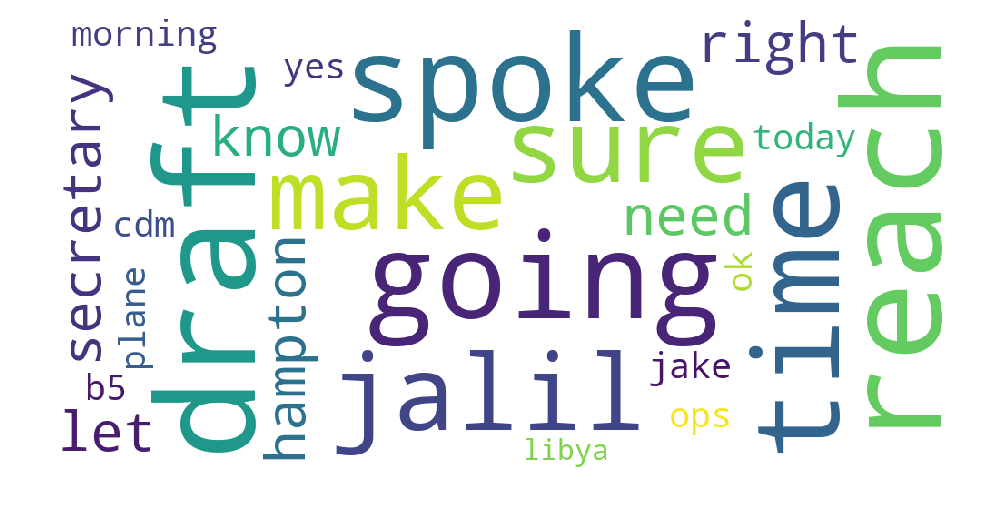

In [33]:
n_samples = 2000
n_features = 1000
n_components = 1
n_top_words = 25

first = False
for day in popular_days:
    
    if(first):
        continue
    first = True
    
    topics = []
    t0 = time()

    data_samples = popular_days[day]
    
    date = datetime.datetime.fromtimestamp(int(day/1000)).strftime('%Y-%m-%d')
    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))

    # Fit the NMF model
    print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
          "tf-idf features, n_samples=%d and n_features=%d..."
          % (n_samples, n_features))
    t0 = time()
    nmf = NMF(n_components=n_components, random_state=1,
              beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
              l1_ratio=.5).fit(tfidf)
    print("done in %0.3fs." % (time() - t0))

    print("\nTopics in NMF model for: " + date)
    model = nmf
    feature_names = tfidf_vectorizer.get_feature_names()
    idf = tfidf_vectorizer.idf_

    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: \n" % topic_idx
        message += "".join([feature_names[i] + " " + str(idf[i]) + "\n"
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        #print(message + "\n")

        text = ""
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            for j in range(int(idf[i])):
                text = feature_names[i] + " " + text

        topics.append(text)

    for topic_idx,topic in enumerate(topics):

        # Generate a word cloud image
        wordcloud = WordCloud().generate(topic)

        # Display the generated image:
        # the matplotlib way:
        # take relative word frequencies into account, lower max_font_size
        wordcloud = WordCloud(max_font_size=150,width=1024,height=512,
                              background_color='white',collocations=False,margin=10).generate(topic)
        plt.figure(figsize=(12, 12),dpi=100)
        plt.imshow(wordcloud)
        plt.axis("off")

        pic_name = 'benghazi_'+str(topic_idx)+'.png'
        plt.savefig(pic_name)

        plt.show()
    

The wordcloud for this particular was not as exciting as i had hoped for. In the lower right corner you can see it says "Libya" but other than that, this topic does not seem out of the ordinary, quite a letdown for such an eventful day!

# Conclusion
The purpose of the project was to figure out who the most central persons where and what they talked about. We have done that and found a selection of influential and central persons. The result which we found was not so much that mails contained classified state secrets as it was mails containing requests like "pls print" and meeting schedules. We found a nice community partitioning in the network, and saw that the topics extracted did have some resemblance to the real world based on the job titles of the central persons within the communities. We then found an interesting day by looking at the mail density over time. Spending some time with mails from that day might prove to be an exciting read.

Parsing and extracting the correct information from this many PDFs of verying templates and styles proved to be very difficult. I managed to get quite good results using regular expressions, but i know for some emails the parsing has not been perfect. For furhter work it would be required to write a better parser that can recursively travel through the mail chains, as my parser can only take the top of the email chain, in the hopes that the rest of the chain will be in another document. 

Thank you for reading this Explorers Notebook.